# Mega-hit Videos prediction

### To select the mega-hit videos, the number of views should be the decisive factor. The number of likes, dislikes and comments could imply the number of views, and the days a video has been published would also have a effect on it. Thus choose this four factor as the input, and the number of views as the output, then use this output to determine if a video is popular. (Though category would probably affect, the number of categories is too large to use one-hot method for pre-processing and the category ids vary among different databases, which would additionally increase the input complexity)

### All the csv files are used in this study. 

## 1.Data Pre-processing

In [293]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

In [131]:
df1 = pd.read_csv("USvideos.csv")
df1.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [167]:
#combine all datasets together
df = pd.read_csv("CAvideos.csv",encoding = "ISO-8859-1")
reg = ["DE","FR","GB","IN","JP","KR","MX","RU","US"]
for pos in reg:
    file = pos + "videos.csv"
    df0 = pd.read_csv(file,encoding = "ISO-8859-1")
    df = pd.concat([df,df0],ignore_index=True)

In [133]:
def days_released(time):
    '''return the number of days from the release date to that when the database is released'''
    #transfer publish_time to release date
    date = time.split("T")[0]
    date = datetime.strptime(date,'%Y-%m-%d').date()
    #the database release date
    rel_time = datetime.strptime("2018-11-29",'%Y-%m-%d').date() 
    return (rel_time - date).days

In [168]:
#feature selection
df["published_days"] = df["publish_time"].apply(lambda x:days_released(x))
df = df[["title","category_id","views","published_days","likes","dislikes","comment_count"]]

In [178]:
#select input and output
X = df[["published_days","likes","dislikes","comment_count"]].values
y = df["views"].values

In [177]:
def train_test_generation(X,Y):
    '''
    Generate train and test dataset,train_test_split would generate different result each time,
    thus write the developped result into csv files and read them again.
    This would make sure that the result of machine learning algorithms would not change when the whole program is rerun  
    '''
    X_train,X_test,y_train,y_test=train_test_split(X,Y)
    np.savetxt("train_and_test/X_train.csv",X_train,delimiter=",")
    np.savetxt("train_and_test/y_train.csv",y_train,delimiter=",")
    np.savetxt("train_and_test/X_test.csv",X_test,delimiter=",")
    np.savetxt("train_and_test/y_test.csv",y_test,delimiter=",")

##  2. Model Development and Selection

In [183]:
#do not run this code if you want to use the previous train and test dataset
# train_test_generation(X,Y)

#read the previous dataset
X_train = pd.read_csv("train_and_test/X_train.csv",header=None).values
y_train = pd.read_csv("train_and_test/y_train.csv",header=None).values
X_test = pd.read_csv("train_and_test/X_test.csv",header=None).values
y_test = pd.read_csv("train_and_test/y_test.csv",header=None).values

In [184]:
def SimpleRegression(train_data, train_labels):
    """
    Runs OLS on the given data.
    
    Args:
        train_data ((n,p) np.array): n is the number of training points and p the number of features
        train_labels ((n,1) np.array): training labels for the training data    
    
    Returns
        tuple: (w, b) where w is a (p,1) weight vector, and b the bias term     
    """
    regressor = LinearRegression()  
    regressor.fit(train_data, train_labels)
    b = regressor.intercept_
    w = regressor.coef_
    
    return (w,b)

In [185]:
# run cv on linear regression(i.e. lambda = 0)
clf = LinearRegression()  
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("CV score when lambda=0: " + str(np.mean(scores)))

CV score when lambda=0: 0.6952900433836395


In [194]:
w,b = SimpleRegression(X_train, y_train)
y_test_pred = np.matmul(X_test, w.T) + b
mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
print("coefficient: "+str(w[0]))
print("intercept: "+str(b[0]))
print("MSE error: "+str(mse[0]))

coefficient: [-217.08203388   47.82096303  116.79429389 -177.17719269]
intercept: 82484.1118456258
MSE error: 15433411971867.74


In [195]:
def RidgeRegression(train_data, train_labels, lambda_):
    """
    Runs linear regression with L2 regularization (ridge) on the given data.
    
    Args:
        train_data ((n,p) np.array): n is the number of training points and p the number of features
        train_labels ((n,1) np.array): training labels for the training data    
        lambda_  (float): scalar weighting the L2 penalty

    Returns
        tuple: (w, b) where w is a (p,1) weight vector, and b the bias term  
    """

    regressor = Ridge(alpha=lambda_)
    regressor.fit(train_data, train_labels)
    b = regressor.intercept_
    w = regressor.coef_
    
    
    return (w,b)

In [196]:
# run ridge to determine best alpha; use the alpha that gives the best cv score
clf = RidgeCV(alphas=[0.1,1,10,100,500,1000, 5000, 100000, 10000000], cv=5).fit(X_train, y_train)
print("Best lambda to use: " + str(clf.alpha_))
clf = Ridge(clf.alpha_)  
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("CV score at best lambda: " + str(np.mean(scores)))

Best lambda to use: 10000000.0
CV score at best lambda: 0.6952900453401695


In [199]:
w,b = RidgeRegression(X_train, y_train, 10)
y_test_pred = np.matmul(X_test, w.T) + b
mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
print("coefficient: "+str(w[0]))
print("intercept: "+str(b[0]))
print("MSE error: "+str(mse[0]))

coefficient: [-217.08203331   47.82096303  116.79429389 -177.17719269]
intercept: 82484.11168524367
MSE error: 15433411971866.654


In [200]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [201]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 10.1min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.6min finished
/Users/brucesun/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [295]:
scores = cross_val_score(rf_random, X_train, y_train, cv=5)
print("CV score at best lambda: " + str(np.mean(scores)))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  9.0min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.4min finished
/Users/brucesun/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  9.1min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.4min finished
/Users/brucesun/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  8.8min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.1min finished
/Users/brucesun/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  8.9min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.2min finished
/Users/brucesun/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  8.9min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.2min finished
/Users/brucesun/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


CV score at best lambda: 0.9703296080648492


In [202]:
y_test_pred = rf_random.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
  
print("MSE error: "+str(mse[0]))

MSE error: 1084290013297.921


### To sum up, choose RandomForestRegressor which has the smallest MSE error

## 3. RandomForestRegressor Result Analyse and Conclusion

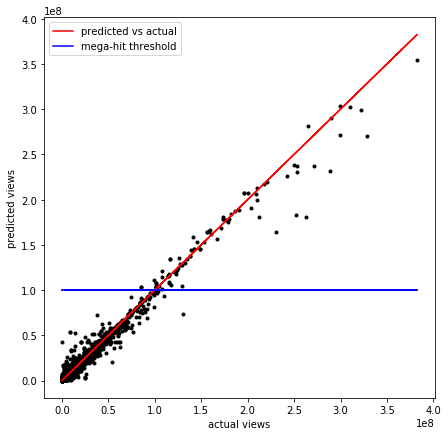

In [292]:
import matplotlib.pyplot as plt
index = [i for i in range(len(y_test))]
flag = [100000000 for i in range(len(y_test))]
plt.figure(figsize=(7,7))
plt.plot(y_test,y_test_pred,"k.")
plt.plot(y_test,y_test,'r',label = "predicted vs actual")
plt.plot(y_test,flag,'b',label = "mega-hit threshold")
plt.xlabel("actual views")
plt.ylabel("predicted views")
plt.legend(loc='upper left')
plt.savefig("comparison.png")

In [ ]:
#label the data
test_label = (y_test > 100000000)
pred_label = (y_test_pred > 100000000)

In [207]:
## Calculates the precision of the predicted labels
def get_precision(y_pred, y_true):
    ## YOUR CODE HERE...
    tp = fp = 0
    for i in range(len(y_pred)):
        if y_pred[i] == True:
            if y_true[i] == True:
                tp += 1
            else:
                fp += 1

    precision = tp/(tp+fp)

    return precision
    
## Calculates the recall of the predicted labels
def get_recall(y_pred, y_true):
    ## YOUR CODE HERE...
    tp = fn = 0
    for i in range(len(y_pred)):
        if y_true[i] == True:
            if y_pred[i] == True:
                tp += 1
            else:
                fn += 1
    recall = tp/(tp+fn)

    return recall

## Calculates the f-score of the predicted labels
def get_fscore(y_pred, y_true):
    ## YOUR CODE HERE...
    precision = get_precision(y_pred, y_true)
    recall = get_recall(y_pred, y_true)
    fscore = 2*precision*recall/(precision+recall)
    return fscore

In [219]:
print("Precision:",get_precision(test_label,pred_label))
print("Recall:",get_recall(test_label,pred_label))
print("F1-score:",get_fscore(test_label,pred_label))

Precision: 0.9354838709677419
Recall: 0.9666666666666667
F1-score: 0.9508196721311476


## Conclusion

### The developed model could well predict the number of views of a video and whether it is popular or not, given the number of likes, dislikes and comments, and days it has been published.